In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
N = 25
X = np.reshape(np.linspace(0, 0.9, N), (N, 1))
Y = np.cos(10*X**2) + 0.1 * np.sin(100*X)

In [12]:
## EDIT THIS FUNCTION
def poly_features(X, K, basis_function):
    
    # X: inputs of size N x 1
    # K: degree of the polynomial
    # computes the feature matrix Phi (N x (K+1))

    X = X.flatten()
    N = X.shape[0]
    
    if basis_function == 'poly':
        Phi = np.ones((N, K+1))
        for i in range(K):
            Phi[:,i+1] = X**(i+1)
            
    if basis_function == 'trig':
        Phi = np.ones((N, 2*K+1))
        for i in range(K):
            Phi[:,2*i+1] = np.sin(2*np.pi*(i+1)*X) 
            Phi[:,2*i+2] = np.cos(2*np.pi*(i+1)*X)
        
    if basis_function == 'gauss':
        Phi = np.ones((N, K+1))
        mu = np.linspace(-0.5, 1, 10)
        l = 0.1
        for i in range(10):
            Phi[:, i+1] = np.exp(-(X - mu[i])**2/(2*l**2))
    
    return Phi

In [13]:
def nonlinear_features_maximum_likelihood(Phi, y):
    # Phi: features matrix for training inputs. Size of N x D
    # y: training targets. Size of N by 1
    # returns: maximum likelihood estimator theta_ml. Size of D x 1

    kappa = 1e-08 # 'jitter' term; good for numerical stability
    theta_ml = np.matmul(
                         np.linalg.inv(
                                        np.matmul(Phi.T, Phi)
                                        ),
                         np.matmul(Phi.T, y)
                        )
    return theta_ml

In [14]:
def linear_reg(K, basis, interval, num_test_point):
    #print(K)
    Phi = poly_features(X, K, basis) # N x (K+1) feature matrix
    theta_ml = nonlinear_features_maximum_likelihood(Phi, Y) # maximum likelihood estimator
    
    # test inputs
    Xtest = np.linspace(start = interval[0], stop = interval[1], num = num_test_point).reshape(-1,1)
    
    # feature matrix for test inputs
    Phi_test = poly_features(Xtest, K, basis)
    y_pred = np.matmul(Phi_test, theta_ml)

    plt.plot(Xtest, y_pred)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.legend
    plt.ylim(-1.5, 2)


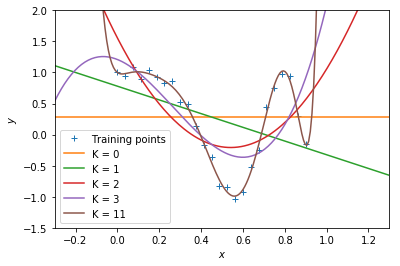

In [15]:
K = [0, 1, 2, 3, 11]
plt.figure()
plt.plot(X, Y, '+')
for i in range(len(K)):
      linear_reg(K[i], 'poly', [-0.3, 1.3], 200)
plt.legend(('Training points', 'K = {}'.format(K[0]),'K = {}'.format(K[1]),
            'K = {}'.format(K[2]),'K = {}'.format(K[3]),
            'K = {}'.format(K[4])))
plt.xlim((-0.3, 1.3))
plt.savefig('ploy_test' + '.eps', bbox_inches='tight')

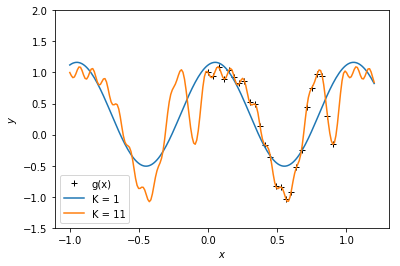

In [16]:
K = [1, 11]
plt.figure()
plt.plot(X, Y, 'k+')
for i in range(len(K)):
      linear_reg(K[i], 'trig', [-1, 1.2], 200)
plt.legend(('g(x)','K = {}'.format(K[0]),'K = {}'.format(K[1])))
plt.savefig('trig_test' + '.eps', bbox_inches='tight')

In [17]:
def cross_val(X, Y, K, basis):
    
    err_test = np.zeros((Y.shape[0]))
    err_train = np.zeros((Y.shape[0]))
    
    for i in range(Y.shape[0]):
        X_test = X[i]
        Y_test = Y[i]
        
        X_train = np.vstack((X[0:i,:], X[i+1:,:]))
        Y_train = np.vstack((Y[0:i,:], Y[i+1:,:]))
        
        phi_train = poly_features(X_train, K, basis)
        phi_test = poly_features(X_test, K, basis)
        
        theta_ml = nonlinear_features_maximum_likelihood(phi_train, Y_train) # maximum likelihood estimator
        
        y_pred_test = np.matmul(phi_test, theta_ml)
        err_test[i] = (Y_test - y_pred_test)**2
        
        y_pred_train = np.matmul(phi_train, theta_ml)
        err_train[i] = np.mean((Y_train - y_pred_train)**2)
    
    var = np.mean(err_train)
    rmse = np.mean(err_test)
    
    return var, rmse

In [18]:
def plot_over_k(k):
    rmse = []
    var = []
    for i in range(k+1):
        v, rm = cross_val(X, Y, i, 'trig')
        var.append(v)
        rmse.append(rm)
    #plt.plot(rmse, label='MSE')
    #plt.plot(var, label=r'$s^{2}$')
    #plt.xlabel('Order of basis')
    #plt.ylabel('Average Error')
    #plt.legend()
    #plt.savefig('test_error_trig' + '.eps', bbox_inches='tight')
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    color = 'tab:red'
    ax.set_xlabel('Order of basis functions')
    ax.set_ylabel('Average error on test data', color=color)
    lns1 = ax.plot(rmse, '--o', label='MSE', color=color)
    ax.tick_params(axis='y', labelcolor=color)
    
    color = 'tab:blue'
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Maximum likelihood variance', color=color)  # we already handled the x-label with ax1
    lns2 = ax2.semilogy(var, '--o', label=r'$\sigma^{2}$',color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig('test_error_trig' + '.eps', bbox_inches='tight')

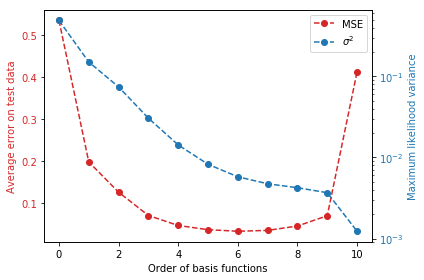

In [19]:
plot_over_k(10)

In [20]:
def lml(alpha, beta, Phi, Y): #used minus for now
    
    N = Y.shape[0]
    PPt = np.matmul(Phi, Phi.T)
    loml = -1/2 * (N * np.log(2 * np.pi) 
                  + np.log(np.linalg.det(alpha * PPt + beta * np.identity(N)))
                  + np.matmul(Y.T, np.matmul(np.linalg.inv(alpha * PPt + beta * np.identity(N)),Y)))
    return loml[0][0]

In [21]:
Phi = poly_features(X, 2, 'trig')
loml = lml(0.5, 0.5, Phi, Y)
loml

-23.832717735508048

In [22]:
def grad_lml(alpha, beta, Phi, Y): #used minus for now
    
    N = Y.shape[0]
    
    PPt = np.matmul(Phi, Phi.T)
    Im = np.linalg.inv(alpha * PPt + beta * np.identity(N))
    
    grad_lml_a = -1/2*(np.trace(np.matmul(PPt, Im)) - np.matmul(Y.T, np.matmul(Im, np.matmul(PPt, np.matmul(Im, Y)))))
    
    grad_lml_b = -1/2*(np.trace(Im) - np.matmul(Y.T, np.matmul(Im, np.matmul(Im, Y))))
    
    grad_lml = np.array([grad_lml_a, grad_lml_b]).reshape(2, 1)
    
    return grad_lml

In [23]:
grad_lml(0.5,0.5,Phi, Y)

array([[ -3.11361191],
       [-16.46527337]])

In [135]:
def grad_des_lml(iters, step, ab_init, Phi, Y):
    ab = np.reshape(ab_init, (2, 1))
    for i in range(iters):
        ab_new = np.reshape(ab[:,i] + step*np.transpose(grad_lml(ab[0,i], ab[1,i], Phi, Y)), (2, 1))
        ab = np.append(ab, ab_new, axis = 1)
    return ab

In [261]:
def plot_grad_des(alpha_min, alpha_max, beta_min, beta_max, nb_points, Phi, Y):
    
    alpha_plot = np.linspace(alpha_min, alpha_max, nb_points)
    beta_plot = np.linspace(beta_min, beta_max, nb_points)
    aa_cont, bb_cont = np.meshgrid(alpha_plot, beta_plot)
    coor = np.array([aa_cont, bb_cont])
    print(coor.shape)
    z = np.zeros((np.size(alpha_plot), np.size(beta_plot)))
    
    for i in range (np.size(alpha_plot)):
        for j in range (np.size(beta_plot)):
            mat_cont = coor[:, i, j].reshape((2, 1))
            z[i, j] = lml(mat_cont[0], mat_cont[1], Phi, Y)
            
    return (alpha_plot, beta_plot, z)

In [646]:
def grad_des_poly(K, initial, learning, iterations, alpha_min, alpha_max, beta_min, beta_max, nb_points, X, Y, basis_function):
    #for order in range(K+1):
    Phi = poly_features(X, K, basis_function)
    points = plot_grad(initial, learning, iterations, alpha_min, alpha_max, beta_min, beta_max, nb_points, Phi, Y)
    return points

In [700]:
def plot_grad(initial, learning, iterations, alpha_min, alpha_max, beta_min, beta_max, nb_points, Phi, Y):
    
    points = grad_des_lml(iterations, learning, initial, Phi, Y)
    (alpha_plot, beta_plot, z) = plot_grad_des(alpha_min, alpha_max, beta_min, beta_max, nb_points, Phi, Y)
    
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_aspect('equal')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.scatter(points[0,:], points[1,:], color = 'r', s=20, marker='x', label = 'Gradient Ascent iterations')
    plt.plot(points[0,:], points[1,:], color = 'r', linewidth=1)
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\beta$')
    plt.figaspect(1)
    #contours = plt.contour(alpha_plot, beta_plot, z, 10) #colors='black'
    #plt.clabel(contours, inline=True, fontsize=10, fmt = '%2.2f')
    #plt.savefig('grad_desc_func_{}_{}_{}'.format(K, initial, learning) + '.eps', bbox_inches='tight')
    #plt.figure()
    contours = plt.contour(alpha_plot, beta_plot, z, 40) #colors='black'
    plt.clabel(contours, inline=True, fontsize=10, fmt = '%2.2f')
    plt.legend()
    plt.savefig('grad_ascent' + '.eps', bbox_inches='tight')
    return points

(2, 100, 100)


array([0.42145885, 0.44937063])

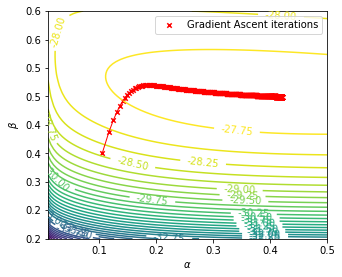

In [701]:
points = grad_des_poly(1, np.array([0.105, 0.35]), 0.003, 800, 0.01, 0.5, 0.2, 0.6, 100, X, Y, 'poly')
Phi = poly_features(X, 1, 'poly')
lml(points[:,-1][0], points[:,-1][0], Phi, Y)
points[:,-1]

In [721]:
def hey_cutie(K, Y, X):
    max_points = np.zeros((2,1))
    max_values = np.zeros(K)
    for i in range(K):
        Phi = poly_features(X, i, 'trig')
        points = grad_des_lml(5000, 0.0000001, [0.105, 0.1], Phi, Y)
        max_points = points[:, -1].copy()
        max_values[i] = lml(max_points[0], max_points[1], Phi, Y)
    plt.figure()
    plt.plot(np.arange(max_values.shape[0]),max_values, '--o')
    plt.ylabel('lml')
    plt.xlabel('Order')
    plt.savefig('gradient_ascents_trig' + '.eps', bbox_inches = 'tight')
    return

In [722]:
%matplotlib inline

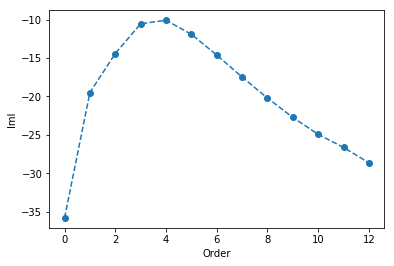

In [723]:
hey_cutie(13, Y, X)

In [373]:
def gauss_features(X):
    X = X.flatten()
    N = X.shape[0]
    
    Phi = np.ones((N, 11))
    mu = np.linspace(-0.5, 1, 10)
    l = 0.1
    for i in range(10):
        Phi[:, i+1] = np.exp(-(X - mu[i])**2/(2*l**2))
    return Phi

In [530]:
def sample(nb_samples, X, Y):
    beta = 0.1
    alpha = 1
    
    Phi = gauss_features(X)
    So = np.identity(Phi.shape[1])/alpha
    mo = np.zeros((Phi.shape[1],1))
    
    cov = np.linalg.inv(np.linalg.inv(So) + beta**(-1) * np.matmul(Phi.T, Phi))
    mean = np.matmul(cov, (np.matmul(np.linalg.inv(So), mo) + beta**(-1) * np.matmul(Phi.T, Y)))
    
    mean = mean.flatten()
    samples = np.random.multivariate_normal(mean, cov, nb_samples)

    return samples, mean, cov

In [514]:
#np.random.seed(seed =0)
(samples, mean, cov) = sample(5, X, Y)
samples.shape

(5, 11)

In [663]:
def predicts(nb_samples, X, Y, beta):

    (samples, mean, cov) = sample(nb_samples, X, Y)
    
    X_test = np.linspace(-1, 1.5, 100)
    beta = beta * np.ones_like(X_test)
    Phi = gauss_features(X_test)
    predict = np.zeros((samples.shape[0], X_test.size))
    
    plt.figure(figsize=(8, 6))
    
    for i in range(samples.shape[0]):
        predictions = np.matmul(Phi, samples[i, :])
        plt.plot(X_test, np.matmul(Phi, samples[i, :]), color = 'blue', alpha = 0.4)
        predict[i,:] = predictions
    
    mean = mean.reshape((11,1))
    predict_mean = np.matmul(Phi, mean)
    predict_cov = np.matmul(Phi, np.matmul(cov, Phi.T))
    predict_std = np.zeros_like(predict_mean)
    
    for j in range(predict_mean.shape[0]):
        predict_std[j] = predict_cov[j][j]
    
    predict_mean = predict_mean.flatten()
    predict_std = predict_std.flatten()
    #predict_mean = np.mean(predict, axis = 0) 
    #predict_std = np.std(predict, axis = 0) 
    plt.scatter(X, Y)
    plt.plot(X_test, predict_mean, 'r-')
    plt.fill_between(X_test, predict_mean+2*np.sqrt(predict_std),
                             predict_mean-2*np.sqrt(predict_std), 
                     facecolor='grey', alpha=0.3)
    
    plt.plot(X_test, predict_mean+2*np.sqrt(predict_std + beta), 'r--', alpha = 0.5)
    plt.plot(X_test, predict_mean-2*np.sqrt(predict_std + beta), 'r--', alpha = 0.5)
    plt.xlim(-1, 1.5)
    plt.savefig('t' + '.png', bbox_inches='tight', dpi = 600)

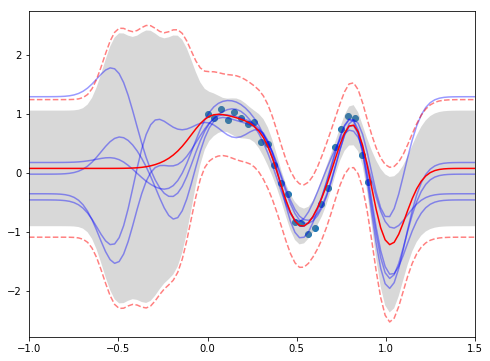

In [670]:
predicts(5, X, Y, 0.1)